In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix
import tensorflow as tf
from tensorflow.python.keras.layers import Dense, Dropout, LSTM
from tensorflow.python.keras import Sequential
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import OrdinalEncoder
from sklearn.utils import class_weight
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

#### load datasets

In [2]:
house_data = pd.read_excel("Clean_Data.xlsx")
house_data

,Date,Time,DateTime,System Setting,System Mode,Calendar Event,Program Mode,Cool Set Temp (C),Heat Set Temp (C),Current Temp (C),...,Thermostat Humidity (%RH),Thermostat Motion,Bedroom (C),Bedroom2,3rd floor landing (C),3rd floor landing2,3rd floor room (C),3rd floor room2,Basement (C),Basement2
0,2020-12-10,12:50:00,2020/12/10 12:50:00,heat,heatOff,auto,Home,21.0,21.0,21.3,...,30.0,1.0,21.6,0.0,20.9,0.0,21.0,0.0,22.8,0.0
1,2020-12-10,12:55:00,2020/12/10 12:55:00,heat,heatOff,auto,Home,21.0,21.0,21.1,...,32.0,1.0,21.6,0.0,20.9,0.0,20.9,0.0,22.7,1.0
2,2020-12-10,13:00:00,2020/12/10 13:00:00,heat,heatOff,auto,Home,21.0,21.0,20.9,...,32.0,0.0,21.6,0.0,20.8,0.0,20.8,0.0,22.7,1.0
3,2020-12-10,13:05:00,2020/12/10 13:05:00,heat,heatOff,auto,Home,21.0,21.0,20.7,...,33.0,0.0,21.6,0.0,20.8,0.0,20.8,0.0,22.8,0.0
4,2020-12-10,13:10:00,2020/12/10 13:10:00,heat,heatStage1On,auto,Home,21.0,21.0,20.6,...,33.0,1.0,21.6,0.0,20.8,0.0,20.8,0.0,22.8,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29671,2021-03-23,14:25:00,2021/3/23 14:25:00,heat,heatOff,NaN,Home,21.0,21.0,21.2,...,21.0,0.0,21.9,0.0,21.8,0.0,21.3,0.0,22.0,1.0
29672,2021-03-23,14:30:00,2021/3/23 14:30:00,heat,heatOff,NaN,Home,21.0,21.0,21.1,...,21.0,0.0,21.9,0.0,21.8,0.0,21.3,0.0,22.1,0.0
29673,2021-03-23,14:35:00,2021/3/23 14:35:00,heat,heatOff,NaN,Home,21.0,21.0,21.1,...,21.0,0.0,21.9,0.0,21.8,1.0,21.3,0.0,22.1,0.0
29674,2021-03-23,14:40:00,2021/3/23 14:40:00,heat,heatOff,NaN,Home,21.0,21.0,21.1,...,21.0,0.0,21.9,0.0,21.8,1.0,21.3,0.0,22.1,0.0


In [3]:
enc = preprocessing.OneHotEncoder()

In [4]:
house_data = house_data.fillna(method = "bfill")
house_data.isnull().sum()

Date                              0
Time                              0
DateTime                          0
System Setting                    0
System Mode                       0
Calendar Event                29548
Program Mode                      0
Cool Set Temp (C)                 0
Heat Set Temp (C)                 0
Current Temp (C)                  0
Current Humidity (%RH)            0
Outdoor Temp (C)                  0
Wind Speed (km/h)                 0
Cool Stage 1 (sec)                0
Heat Stage 1 (sec)                0
Fan (sec)                         0
Thermostat Temperature (C)        0
Thermostat Humidity (%RH)         0
Thermostat Motion                 0
Bedroom (C)                       0
Bedroom2                          0
3rd floor landing (C)             0
3rd floor landing2                0
3rd floor room (C)                0
3rd floor room2                   0
Basement (C)                      0
Basement2                         0
dtype: int64

#### same as approch b, build new datasets

In [5]:
numerical_vars = ['Heat Set Temp (C)', 'Current Temp (C)', 'Current Humidity (%RH)', 'Outdoor Temp (C)','Thermostat Temperature (C)', 'Thermostat Humidity (%RH)']
sc = StandardScaler()
sc.fit(house_data[numerical_vars])
scalar_data = sc.transform(house_data[numerical_vars])

In [16]:
y_auxHeat = house_data['Heat Stage 1 (sec)'].to_numpy()
#oe = OrdinalEncoder()
#y_auxHeat = oe.fit_transform(y_auxHeat.reshape(-1, 1))

In [17]:
scaler_house_data = house_data[numerical_vars].copy()
scaler_house_data[numerical_vars] = scalar_data
scaler_house_data["Heat Stage 1"] = y_auxHeat

In [18]:
scaler_house_data

,Heat Set Temp (C),Current Temp (C),Current Humidity (%RH),Outdoor Temp (C),Thermostat Temperature (C),Thermostat Humidity (%RH),Heat Stage 1
0,0.0,2.632689,1.422976,1.387394,2.632689,1.422976,0.0
1,0.0,1.489502,1.930176,1.387394,1.489502,1.930176,0.0
2,0.0,0.346315,1.930176,1.424799,0.346315,1.930176,0.0
3,0.0,-0.796872,2.183776,1.424799,-0.796872,2.183776,135.0
4,0.0,-1.368465,2.183776,1.424799,-1.368465,2.183776,300.0
...,...,...,...,...,...,...,...
29671,0.0,2.061095,-0.859425,3.295068,2.061095,-0.859425,0.0
29672,0.0,1.489502,-0.859425,3.388582,1.489502,-0.859425,0.0
29673,0.0,1.489502,-0.859425,3.388582,1.489502,-0.859425,0.0
29674,0.0,1.489502,-0.859425,3.388582,1.489502,-0.859425,0.0


##### use time-Lag build predictor. this function used to build time-lag datasets

In [19]:
def series_to_supervised(data, n_in = 1, n_out = 1, dropnan = True):
    
    n_vars = data.shape[1]
    columns = data.columns
    df = pd.DataFrame(data)
    
    df_new = pd.DataFrame()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        for j in range(n_vars):
            df_new['var%d(t-%d)' % (j+1, i)] = df.shift(i)[columns[j]]
   
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        
        for j in range(n_vars):
            if i == 0:
                name = 'var%d(t)' % (j+1)
            else:
                name = 'var%d(t+%d)' % (j+1, i)
            df_new[name] = df.shift(-i)[columns[j]]
    
    if dropnan:
        df_new.dropna(inplace=True)
    return df_new

#### generate 30-minutes time-lag datasets

In [20]:
reframed = series_to_supervised(scaler_house_data, 6, 1)
reframed

,var1(t-6),var2(t-6),var3(t-6),var4(t-6),var5(t-6),var6(t-6),var7(t-6),var1(t-5),var2(t-5),var3(t-5),...,var5(t-1),var6(t-1),var7(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t)
6,0.0,2.632689,1.422976,1.387394,2.632689,1.422976,0.0,0.0,1.489502,1.930176,...,-0.796872,2.183776,300.0,0.0,-0.225278,2.183776,1.424799,-0.225278,2.183776,300.0
7,0.0,1.489502,1.930176,1.387394,1.489502,1.930176,0.0,0.0,0.346315,1.930176,...,-0.225278,2.183776,300.0,0.0,0.917909,2.183776,1.424799,0.917909,2.183776,45.0
8,0.0,0.346315,1.930176,1.424799,0.346315,1.930176,0.0,0.0,-0.796872,2.183776,...,0.917909,2.183776,45.0,0.0,1.489502,2.183776,1.462204,1.489502,2.183776,0.0
9,0.0,-0.796872,2.183776,1.424799,-0.796872,2.183776,135.0,0.0,-1.368465,2.183776,...,1.489502,2.183776,0.0,0.0,1.489502,2.183776,1.462204,1.489502,2.183776,0.0
10,0.0,-1.368465,2.183776,1.424799,-1.368465,2.183776,300.0,0.0,-0.796872,2.183776,...,1.489502,2.183776,0.0,0.0,0.917909,2.183776,1.462204,0.917909,2.183776,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29671,0.0,3.204282,-0.098625,3.238960,3.204282,-0.098625,0.0,0.0,3.204282,-0.098625,...,2.061095,-0.859425,0.0,0.0,2.061095,-0.859425,3.295068,2.061095,-0.859425,0.0
29672,0.0,3.204282,-0.098625,3.295068,3.204282,-0.098625,0.0,0.0,2.632689,-0.605825,...,2.061095,-0.859425,0.0,0.0,1.489502,-0.859425,3.388582,1.489502,-0.859425,0.0
29673,0.0,2.632689,-0.605825,3.295068,2.632689,-0.605825,0.0,0.0,2.632689,-0.605825,...,1.489502,-0.859425,0.0,0.0,1.489502,-0.859425,3.388582,1.489502,-0.859425,0.0
29674,0.0,2.632689,-0.605825,3.295068,2.632689,-0.605825,0.0,0.0,2.061095,-0.605825,...,1.489502,-0.859425,0.0,0.0,1.489502,-0.859425,3.388582,1.489502,-0.859425,0.0


### target variable

In [21]:
y_auxHeat = reframed['var7(t)']
#y_auxHeat = to_categorical(y_auxHeat)

In [22]:
y_auxHeat

6        300.0
7         45.0
8          0.0
9          0.0
10         0.0
         ...  
29671      0.0
29672      0.0
29673      0.0
29674      0.0
29675      0.0
Name: var7(t), Length: 29670, dtype: float64

In [23]:
#test = np.argmax(y_auxHeat, axis = 1)

#### check target variable distribution

In [24]:
#(unique, counts) = np.unique(test, return_counts = True)
#frequencies = np.asarray((unique, counts)).T
#frequencies

In [25]:
#plt.hist(frequencies)
#plt.show()

In [26]:
X = reframed.drop(labels = ['var7(t)'], axis = 1)

In [27]:
np.array(y_auxHeat).reshape(-1,1)

array([[300.],
       [ 45.],
       [  0.],
       ...,
       [  0.],
       [  0.],
       [  0.]])

In [28]:
sc = StandardScaler()
sc.fit(np.array(y_auxHeat).reshape(-1,1))
y_auxHeat = sc.transform(np.array(y_auxHeat).reshape(-1,1))

In [29]:
X_train = X.iloc[:23680,]
y_train = y_auxHeat[:23680,]
X_test = X.iloc[23680:]
y_test = y_auxHeat[23680:]

In [18]:
#test = np.argmax(y_train, axis = 1)

In [31]:
from sklearn.metrics import r2_score
from sklearn import linear_model    
model = linear_model.LinearRegression()

model.fit(X,y_auxHeat)
predict_y = model.predict(X)

r2_score(predict_y,y_auxHeat)

0.5799589917275356

In [19]:
#(unique, counts) = np.unique(test, return_counts = True)
#frequencies = np.asarray((unique, counts)).T

In [112]:
X_train.shape,X_test.shape

((23680, 48), (5990, 48))

In [113]:
X_train = X_train.values
X_test = X_test.values

In [114]:
X_train = X_train.astype(float)
X_test = X_test.astype(float)

In [116]:
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu', input_dim = 48))

# Adding the second hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
classifier.add(Dense(units = 1, kernel_initializer = 'normal', activation = 'linear'))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'mean_absolute_error', metrics = ['mse']) 

# Fitting the ANN to the Training set
history = classifier.fit(X_train, y_train, validation_data = (X_test, y_test), batch_size = 64, epochs = 50, shuffle = True)

Epoch 1/50
370/370 [==============================] - 0s 863us/step - loss: 0.3827 - mse: 0.3217 - val_loss: 0.2758 - val_mse: 0.1712
Epoch 2/50
370/370 [==============================] - 0s 699us/step - loss: 0.1951 - mse: 0.1257 - val_loss: 0.2176 - val_mse: 0.1203
Epoch 3/50
370/370 [==============================] - 0s 585us/step - loss: 0.1643 - mse: 0.0903 - val_loss: 0.1648 - val_mse: 0.0849
Epoch 4/50
370/370 [==============================] - 0s 675us/step - loss: 0.1523 - mse: 0.0818 - val_loss: 0.1496 - val_mse: 0.0822
Epoch 5/50
370/370 [==============================] - 0s 619us/step - loss: 0.1460 - mse: 0.0792 - val_loss: 0.1323 - val_mse: 0.0734
Epoch 6/50
370/370 [==============================] - 0s 665us/step - loss: 0.1388 - mse: 0.0756 - val_loss: 0.1221 - val_mse: 0.0669
Epoch 7/50
370/370 [==============================] - 0s 595us/step - loss: 0.1352 - mse: 0.0742 - val_loss: 0.1250 - val_mse: 0.0674
Epoch 8/50
370/370 [==============================] - 0s 691us

In [117]:
min(history.history['loss']),min(history.history['val_loss']),min(history.history['mse']),min(history.history['val_mse'])

(0.1111348420381546,
 0.09245443344116211,
 0.06293945014476776,
 0.05827145650982857)

In [118]:
classifier.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 24)                1176      
_________________________________________________________________
dense_16 (Dense)             (None, 24)                600       
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 25        
Total params: 1,801
Trainable params: 1,801
Non-trainable params: 0
_________________________________________________________________


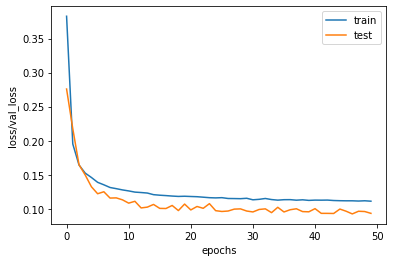

In [119]:
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'test')
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss/val_loss")
plt.savefig("8.png")
plt.show()

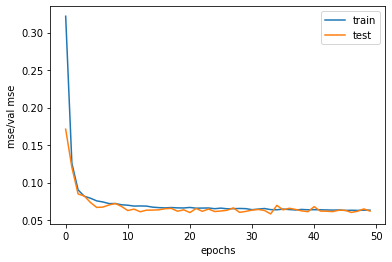

In [121]:
plt.plot(history.history['mse'], label = 'train')
plt.plot(history.history['val_mse'], label = 'test')
plt.legend()
plt.xlabel("epochs")
plt.ylabel("mse/val mse")
plt.savefig("9.png")
plt.show()

In [27]:
y_predicted = classifier.predict(X_test)

In [28]:
y_predicted = np.argmax(y_predicted, axis = 1)
y_predicted

array([9, 0, 0, ..., 0, 0, 0])

In [29]:
y_test = np.argmax(y_test, axis = 1)

In [30]:
test_sum = y_test.sum()*15
test_sum

468105

In [31]:
predicted_sum = y_predicted.sum()*15

In [32]:
predicted_sum

489765

#### caculate error percentage

In [33]:
print("Error Percentage in predicted values is : {} %".format(np.absolute((predicted_sum - test_sum)/test_sum)*100))

Error Percentage in predicted values is : 4.627166981766911 %


In [34]:
from sklearn.metrics import mean_absolute_error,f1_score,accuracy_score

In [35]:
y_train_predicted = classifier.predict(X_train)
y_train_predicted = np.argmax(y_train_predicted, axis = 1)
y_train = np.argmax(y_train, axis = 1)

In [36]:
f1_score(y_train, y_train_predicted, average = 'weighted')

0.7020419140268691

In [37]:
accuracy_score(y_train, y_train_predicted)

0.7489864864864865

In [38]:
mean_absolute_error(y_train, y_train_predicted)

1.102956081081081

In [39]:
mean_absolute_error(y_test, y_predicted)

0.8991652754590985

In [40]:
accuracy_score(y_test, y_predicted)

0.8120200333889817

In [41]:
f1_score(y_test, y_predicted, average = 'weighted')

0.784762756112307

### generate 60-minutes time-lag datasets

In [32]:
reframed_2 = series_to_supervised(scaler_house_data, 12, 1)
reframed_2

,var1(t-12),var2(t-12),var3(t-12),var4(t-12),var5(t-12),var6(t-12),var7(t-12),var1(t-11),var2(t-11),var3(t-11),...,var5(t-1),var6(t-1),var7(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t)
12,0.0,2.632689,1.422976,1.387394,2.632689,1.422976,0.0,0.0,1.489502,1.930176,...,0.346315,2.183776,0.0,0.0,-0.225278,2.183776,1.462204,-0.225278,2.183776,0.0
13,0.0,1.489502,1.930176,1.387394,1.489502,1.930176,0.0,0.0,0.346315,1.930176,...,-0.225278,2.183776,0.0,0.0,-0.225278,2.183776,1.462204,-0.225278,2.183776,0.0
14,0.0,0.346315,1.930176,1.424799,0.346315,1.930176,0.0,0.0,-0.796872,2.183776,...,-0.225278,2.183776,0.0,0.0,-0.796872,2.183776,1.443502,-0.796872,2.183776,255.0
15,0.0,-0.796872,2.183776,1.424799,-0.796872,2.183776,135.0,0.0,-1.368465,2.183776,...,-0.796872,2.183776,255.0,0.0,-0.796872,2.183776,1.443502,-0.796872,2.183776,300.0
16,0.0,-1.368465,2.183776,1.424799,-1.368465,2.183776,300.0,0.0,-0.796872,2.183776,...,-0.796872,2.183776,300.0,0.0,0.346315,2.183776,1.443502,0.346315,2.183776,90.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29671,0.0,3.204282,-0.098625,3.145447,3.204282,-0.098625,0.0,0.0,3.204282,-0.098625,...,2.061095,-0.859425,0.0,0.0,2.061095,-0.859425,3.295068,2.061095,-0.859425,0.0
29672,0.0,3.204282,-0.098625,3.238960,3.204282,-0.098625,0.0,0.0,3.204282,-0.098625,...,2.061095,-0.859425,0.0,0.0,1.489502,-0.859425,3.388582,1.489502,-0.859425,0.0
29673,0.0,3.204282,-0.098625,3.238960,3.204282,-0.098625,0.0,0.0,3.204282,-0.098625,...,1.489502,-0.859425,0.0,0.0,1.489502,-0.859425,3.388582,1.489502,-0.859425,0.0
29674,0.0,3.204282,-0.098625,3.238960,3.204282,-0.098625,0.0,0.0,3.204282,-0.098625,...,1.489502,-0.859425,0.0,0.0,1.489502,-0.859425,3.388582,1.489502,-0.859425,0.0


In [33]:
y_auxHeat = reframed_2['var7(t)']
#y_auxHeat = to_categorical(y_auxHeat)
#X.shape

In [34]:
X = reframed_2.drop(labels = ['var7(t)'], axis = 1)

sc = StandardScaler()
sc.fit(np.array(y_auxHeat).reshape(-1,1))
y_auxHeat = sc.transform(np.array(y_auxHeat).reshape(-1,1))

X_train = X.iloc[:23680,]
y_train = y_auxHeat[:23680,]
X_test = X.iloc[23680:]
y_test = y_auxHeat[23680:]

In [35]:
from sklearn.metrics import r2_score
from sklearn import linear_model    
model = linear_model.LinearRegression()

model.fit(X,y_auxHeat)
predict_y = model.predict(X)

r2_score(predict_y,y_auxHeat)

0.6209662862841873

In [45]:
# X_train = X_train.astype(float)
# X_test = X_test.astype(float)
# X_train.shape

In [125]:
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu', input_dim = 90))

# Adding the second hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
classifier.add(Dense(units = 1, kernel_initializer = 'normal', activation = 'linear'))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'mean_absolute_error', metrics = ['mse']) 

# Fitting the ANN to the Training set
history = classifier.fit(X_train, y_train, validation_data = (X_test, y_test), batch_size = 64, epochs = 50, shuffle = True)

Epoch 1/50
370/370 [==============================] - 0s 894us/step - loss: 0.3485 - mse: 0.2747 - val_loss: 0.2546 - val_mse: 0.1636
Epoch 2/50
370/370 [==============================] - 0s 656us/step - loss: 0.1995 - mse: 0.1288 - val_loss: 0.2034 - val_mse: 0.1093
Epoch 3/50
370/370 [==============================] - 0s 681us/step - loss: 0.1652 - mse: 0.0920 - val_loss: 0.1400 - val_mse: 0.0860
Epoch 4/50
370/370 [==============================] - 0s 729us/step - loss: 0.1506 - mse: 0.0830 - val_loss: 0.1230 - val_mse: 0.0755
Epoch 5/50
370/370 [==============================] - 0s 666us/step - loss: 0.1426 - mse: 0.0774 - val_loss: 0.1223 - val_mse: 0.0755
Epoch 6/50
370/370 [==============================] - 0s 631us/step - loss: 0.1370 - mse: 0.0743 - val_loss: 0.1167 - val_mse: 0.0705
Epoch 7/50
370/370 [==============================] - 0s 689us/step - loss: 0.1335 - mse: 0.0719 - val_loss: 0.1152 - val_mse: 0.0692
Epoch 8/50
370/370 [==============================] - 0s 657us

In [126]:
min(history.history['loss']),min(history.history['val_loss']),min(history.history['mse']),min(history.history['val_mse'])

(0.10534007847309113,
 0.09269772469997406,
 0.05880322679877281,
 0.0564054436981678)

In [127]:
classifier.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 24)                2184      
_________________________________________________________________
dense_19 (Dense)             (None, 24)                600       
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 25        
Total params: 2,809
Trainable params: 2,809
Non-trainable params: 0
_________________________________________________________________


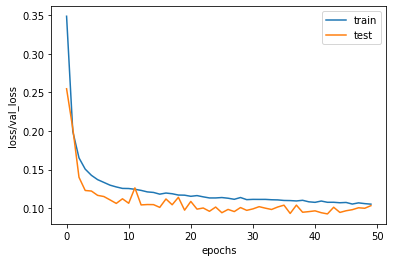

In [128]:
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'test')
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss/val_loss")
plt.savefig("10.png")
plt.show()

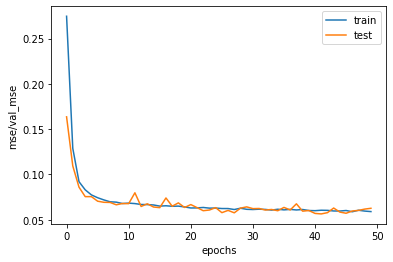

In [131]:
plt.plot(history.history['mse'], label = 'train')
plt.plot(history.history['val_mse'], label = 'test')
plt.legend()
plt.xlabel("epochs")
plt.ylabel("mse/val_mse")
plt.savefig("11.png")
plt.show()

In [50]:
y_predicted = classifier.predict(X_test)
y_predicted = np.argmax(y_predicted, axis = 1)
y_predicted

array([20,  4,  0, ...,  0,  0,  0])

In [51]:
y_test = np.argmax(y_test, axis = 1)

In [52]:
test_sum = y_test.sum()*15
test_sum

467430

In [53]:
predicted_sum = y_predicted.sum()*15
predicted_sum

493110

In [54]:
print("Error Percentage in predicted values is : {} %".format(np.absolute((predicted_sum - test_sum)/test_sum)*100))

Error Percentage in predicted values is : 5.4938707400038505 %


In [55]:
y_train_predicted = classifier.predict(X_train)
y_train_predicted = np.argmax(y_train_predicted, axis = 1)
y_train_predicted

array([ 0,  0,  8, ...,  0, 17, 20])

In [56]:
y_train = np.argmax(y_train, axis = 1)

In [57]:
f1_score(y_train, y_train_predicted, average = 'weighted')

0.7187716889534023

In [58]:
mean_absolute_error(y_train, y_train_predicted)

0.9655827702702703

In [59]:
accuracy_score(y_train, y_train_predicted)

0.7541807432432432

In [60]:
f1_score(y_test, y_predicted, average = 'weighted')

0.7872340485601789

In [61]:
mean_absolute_error(y_test, y_predicted)

0.8866978609625669

In [62]:
accuracy_score(y_test, y_predicted)

0.8116644385026738

#### Grid Search CV to tune parameters in 30-minutes time-lag model.

In [63]:
from sklearn.model_selection import cross_validate, GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

Using TensorFlow backend.


In [64]:
reframed = series_to_supervised(scaler_house_data, 6, 1)
reframed

,var1(t-6),var2(t-6),var3(t-6),var4(t-6),var5(t-6),var6(t-6),var7(t-6),var1(t-5),var2(t-5),var3(t-5),...,var5(t-1),var6(t-1),var7(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t)
6,0.0,2.632689,1.422976,1.387394,2.632689,1.422976,0.0,0.0,1.489502,1.930176,...,-0.796872,2.183776,20.0,0.0,-0.225278,2.183776,1.424799,-0.225278,2.183776,20.0
7,0.0,1.489502,1.930176,1.387394,1.489502,1.930176,0.0,0.0,0.346315,1.930176,...,-0.225278,2.183776,20.0,0.0,0.917909,2.183776,1.424799,0.917909,2.183776,3.0
8,0.0,0.346315,1.930176,1.424799,0.346315,1.930176,0.0,0.0,-0.796872,2.183776,...,0.917909,2.183776,3.0,0.0,1.489502,2.183776,1.462204,1.489502,2.183776,0.0
9,0.0,-0.796872,2.183776,1.424799,-0.796872,2.183776,9.0,0.0,-1.368465,2.183776,...,1.489502,2.183776,0.0,0.0,1.489502,2.183776,1.462204,1.489502,2.183776,0.0
10,0.0,-1.368465,2.183776,1.424799,-1.368465,2.183776,20.0,0.0,-0.796872,2.183776,...,1.489502,2.183776,0.0,0.0,0.917909,2.183776,1.462204,0.917909,2.183776,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29671,0.0,3.204282,-0.098625,3.238960,3.204282,-0.098625,0.0,0.0,3.204282,-0.098625,...,2.061095,-0.859425,0.0,0.0,2.061095,-0.859425,3.295068,2.061095,-0.859425,0.0
29672,0.0,3.204282,-0.098625,3.295068,3.204282,-0.098625,0.0,0.0,2.632689,-0.605825,...,2.061095,-0.859425,0.0,0.0,1.489502,-0.859425,3.388582,1.489502,-0.859425,0.0
29673,0.0,2.632689,-0.605825,3.295068,2.632689,-0.605825,0.0,0.0,2.632689,-0.605825,...,1.489502,-0.859425,0.0,0.0,1.489502,-0.859425,3.388582,1.489502,-0.859425,0.0
29674,0.0,2.632689,-0.605825,3.295068,2.632689,-0.605825,0.0,0.0,2.061095,-0.605825,...,1.489502,-0.859425,0.0,0.0,1.489502,-0.859425,3.388582,1.489502,-0.859425,0.0


In [65]:
y_auxHeat = reframed['var7(t)']
y_auxHeat = to_categorical(y_auxHeat).astype(float)

In [66]:
X = reframed.drop(labels = ['var7(t)'], axis = 1).astype(float)
X.shape

(29670, 48)

In [67]:
def build_classifier(optimizer):

    classifier = Sequential()

    # Adding the input layer and the first hidden layer
    classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu', input_dim = 48))

    # Adding the second hidden layer
    classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu'))

    # Adding the output layer
    classifier.add(Dense(units = 21, kernel_initializer = 'uniform', activation = 'softmax'))

    # Compiling the ANN
    classifier.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    return classifier

In [68]:
classifier = KerasClassifier(build_fn = build_classifier, batch_size = 10, nb_epoch = 20)

In [69]:
scoring = {'acc': 'accuracy'}

parameters = {'batch_size' : [10, 64,100],
              'epochs' : [10, 50],
              'optimizer' : ['adam', 'rmsprop']}

In [70]:
grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring = scoring,
                           refit = False,
                           cv = 10)

In [71]:
grid_search.fit(X, y_auxHeat)

Epoch 1/10
2671/2671 [==============================] - 1s 475us/step - loss: 1.0157 - accuracy: 0.7411
Epoch 2/10
2671/2671 [==============================] - 1s 553us/step - loss: 0.8535 - accuracy: 0.7555
Epoch 3/10
2671/2671 [==============================] - 2s 745us/step - loss: 0.8260 - accuracy: 0.7564
Epoch 4/10
2671/2671 [==============================] - 1s 555us/step - loss: 0.8079 - accuracy: 0.7574
Epoch 5/10
2671/2671 [==============================] - 1s 514us/step - loss: 0.7955 - accuracy: 0.7584
Epoch 6/10
2671/2671 [==============================] - 1s 518us/step - loss: 0.7898 - accuracy: 0.7600
Epoch 7/10
2671/2671 [==============================] - 1s 553us/step - loss: 0.7831 - accuracy: 0.7605
Epoch 8/10
2671/2671 [==============================] - 1s 510us/step - loss: 0.7799 - accuracy: 0.7604
Epoch 9/10
2671/2671 [==============================] - 1s 477us/step - loss: 0.7735 - accuracy: 0.7610
Epoch 10/10
2671/2671 [==============================] - 1s 472u

ValueError: Classification metrics can't handle a mix of multilabel-indicator and multiclass targets

In [ ]:
grid_search.cv_results_

In [ ]:
grid_search.get_params

In [ ]:
grid_search_results = pd.DataFrame(grid_search.cv_results_, columns = list(grid_search.cv_results_.keys()))
grid_search_results

### Cross Validation

In [ ]:
def build_classifier(ac_func):

    classifier = Sequential()

    # Adding the input layer and the first hidden layer
    classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = ac_func, input_dim = 48))

    # Adding the second hidden layer
    classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = ac_func))

    # Adding the output layer
    classifier.add(Dense(units = 21, kernel_initializer = 'uniform', activation = 'softmax'))

    # Compiling the ANN
    classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    return classifier

In [ ]:
ac_funcs = ['relu', 'sigmoid', 'tanh']
ac_funcs_score_time = []
ac_funcs_acc = []
ac_funcs_f1 = []

In [ ]:
X = X.astype(float)
y_auxHeat = y_auxHeat.astype(float)

In [ ]:
classifier = KerasClassifier(build_fn = build_classifier,ac_func =ac_funcs[0],  batch_size = 64, nb_epoch = 50)

In [ ]:
scores = cross_validate(estimator = classifier, X = X, y = y_auxHeat, cv = 10)
scores

In [ ]:
ac_funcs_score_time.append(scores['score_time'])
ac_funcs_acc.append(scores['test_score'])
#ac_funcs_f1.append(scores['test_f1_weighted'])

In [ ]:
X.shape,y_auxHeat.shape

In [ ]:
classifier = KerasClassifier(build_fn = build_classifier,ac_func = ac_funcs[1], batch_size = 64, nb_epoch = 50)


scores = cross_validate(estimator = classifier, X = X, y = y_auxHeat, cv = 10)
ac_funcs_score_time.append(scores['score_time'])
ac_funcs_acc.append(scores['test_score'])

In [ ]:
classifier = KerasClassifier(build_fn = build_classifier, batch_size = 64, nb_epoch = 50)

scoring = {'acc': 'accuracy',
           }

scores = cross_validate(estimator = classifier, X = X, y = y_auxHeat, cv = 10)
ac_funcs_score_time.append(scores['score_time'])
ac_funcs_acc.append(scores['test_score'])

In [ ]:
ac_funcs_acc

In [ ]:
acc_df = pd.DataFrame(ac_funcs_acc)
acc_df = acc_df.T

In [ ]:
acc_df = acc_df.rename(columns = {0:'ReLu', 1:'Sigmoid', 2:'Tanh'})

In [ ]:
acc_df

In [ ]:
plt.figure(figsize = (12, 10))
ax = sns.boxplot(data = acc_df)
ax.set(ylabel = "Accuracy", xlabel = "Activation Function Used")
plt.savefig("12.png")

In [ ]:
time_df = pd.DataFrame(ac_funcs_score_time)
time_df = time_df.T

time_df = time_df.rename(columns = {0:'ReLu', 1:'Sigmoid', 2:'Tanh'})

plt.figure(figsize = (12, 10))
ax = sns.boxplot(data = time_df)
ax.set(ylabel = "Time Taken for Prediction", xlabel = "Activation Function Used")
plt.savefig("14.png")